# Time Series - Recap - Tim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas_datareader.data as web
import datetime as dt

In [3]:
import statsmodels
statsmodels.__version__

'0.13.1'

## Stock Market

### Step 1: Setting up the TS

📆  What day is it today ? 

In [4]:
end = dt.datetime.now()
end

datetime.datetime(2022, 1, 3, 16, 45, 5, 314803)

In [5]:
print(end.year)
print(end.month)
print(end.day)

2022
1
3


👉 Choose a starting date

In [6]:
start = end - dt.timedelta(days=200)
start

datetime.datetime(2021, 6, 17, 16, 45, 5, 314803)

### Financial Data

📚 The `pandas_datareader` is a Python library that you can use to import financial data from Yahoo, the OECD, WorldBank,
[etc.......](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html)

💸 Let's try to predict where the MSCI WORLD ETF price **will close tonight** using ARIMA.

In [7]:
#^NDX nasdaq100
#BTC-USD
#MSFT
#TSLA
#XWD.TO    MSCI WORLD


company = 'XWD.TO'
source = 'yahoo'

In [8]:
# Retrieving the historical values of the Google Stock price
df = web.DataReader(company,
                    source,
                    start = start,
                    end = end)[['Close']].reset_index()

# Making sure we are dealing with Datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# Resetting the dates as indexes
df.set_index(['Date'], inplace=True)


# On a Daily Basis
df = df.asfreq('d')

# Chronological sorting
df.sort_index(inplace=True)


# Filling the missing values , the Nasdaq is closed during the weekends
df = df.ffill() #ffill = forward fill


# Showing the df we are going to work with
df     #last datapoint is yesterdays close

,Close
Date,
2021-06-17,66.853706
2021-06-18,66.402809
2021-06-19,66.402809
2021-06-20,66.402809
2021-06-21,66.693390
...,...
2021-12-27,74.680000
2021-12-28,74.680000
2021-12-29,75.430862


### Visualisation, Transformation and  Decomposition

#### Visualisation

📈 How does my TS look like ?

<AxesSubplot:xlabel='Date'>

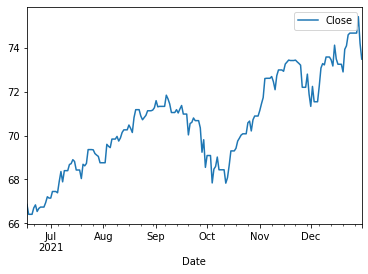

In [9]:
df.plot()

#### Transformation : Linearization (Logarithm)

💡 When TS have exponential growth, it is generally a good idea to use the logarithm to make the plot look more linear.

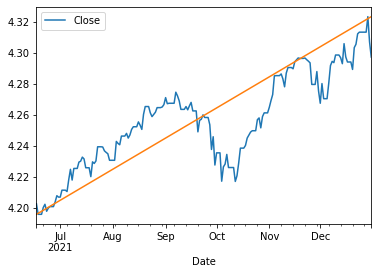

In [10]:
linearized = np.log(df)
linearized.plot()
#plot line
plt.plot([linearized.index[0],linearized.index[-1]],[linearized.min(),linearized.max()])

#### Stationarisation

🤓 TimeSeries Models work better with Stationary TS !

👉 Let's try to differentiate the linearized version of the TS.

👉 A stationary time series is one whose properties do not depend on the time at which the series is observed.

Text(0.5, 1.0, '2nd Order Differencing')

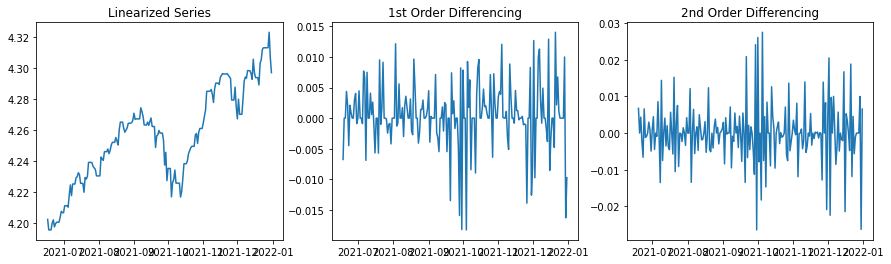

In [11]:
# Let's difference this and look at the ACFs
fig, axes = plt.subplots(1, 3,figsize=(15,4))

axes[0].plot(linearized);
axes[0].set_title('Linearized Series')
             
# 1st Differencing
y_diff = linearized.diff().dropna()
axes[1].plot(y_diff); 
axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff = linearized.diff().diff().dropna()
axes[2].plot(y_diff_diff); 
axes[2].set_title('2nd Order Differencing')

In [12]:
#y_diff.plot(figsize=(14,4))

In [13]:
#y_diff_diff.plot(figsize=(14,4))

👉 Check for stationarity using the Augmented Dickey-Fuller test:

    ❌ Null hypothesis: Stationarity **does not** exist in the series.

     ❗ Alternative Hypothesis: Stationarity **does** exist in the series.
     
[Statsmodel Documentation: Adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adfuller(linearized)

(-1.5327508306256559,
 0.517252274977212,
 1,
 196,
 {'1%': -3.464161278384219,
  '5%': -2.876401960790147,
  '10%': -2.5746921001665974},
 -1383.632282083726)

In [16]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(linearized)[1])
print('p-value first-diff: ', adfuller(linearized.diff().dropna())[1])
print('p-value second-diff: ', adfuller(linearized.diff().diff().dropna())[1])

p-value zero-diff:  0.517252274977212
p-value first-diff:  3.5760531419196334e-29
p-value second-diff:  1.2318217786664238e-09


**Reminder:** 
- A small p-value (<0.05) suggests  strong evidence against H0, so you **reject the null hypothesis**. 👉 Stationary
- A large p-value (> 0.05) indicates weak evidence against H0, so you **fail to reject the null hypothesis**. 👉 Non-stationary

In [17]:
from pmdarima.arima.utils import ndiffs
d = ndiffs(linearized)
d

1

### ARIMA

#### Hyperparameters _p_ and _q_

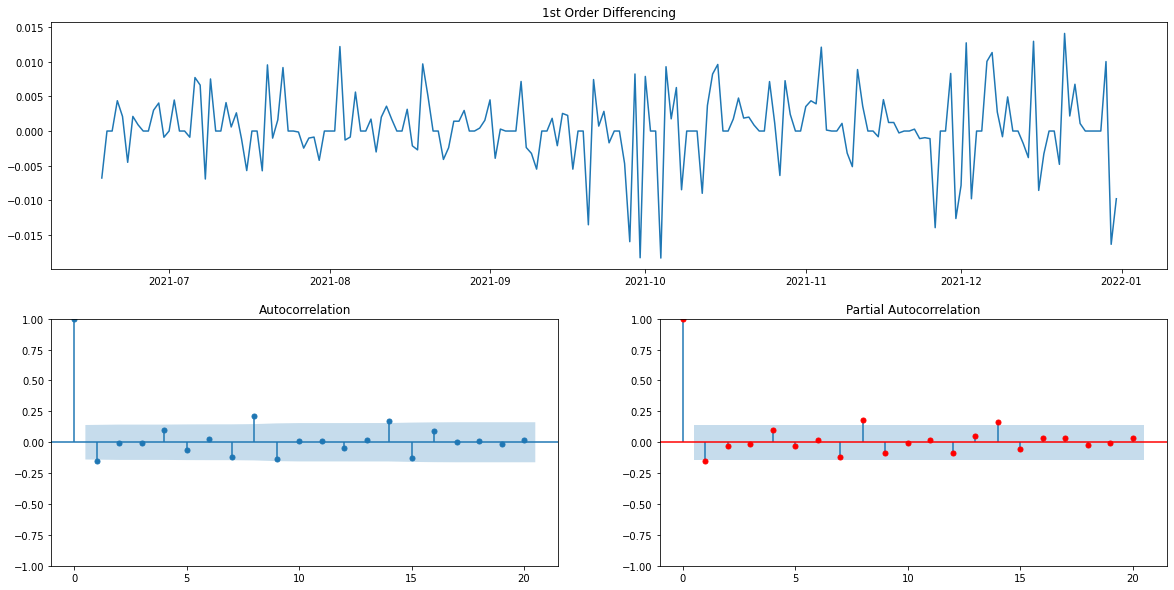

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#figure setup
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title('1st Order Differencing')
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

#plots
ax1.plot(y_diff)
plot_acf(y_diff, lags=20, ax=ax2);
plot_pacf(y_diff, lags=20, ax=ax3, color='r', method='ywm')
plt.show()

We use the **PACF** plot to calculate the value for **p** 

We use the **ACF** plot to calculate the value for **q**

In [19]:
q = 1
p = 1

#### Training the ARIMA

In [20]:
#from statsmodels.tsa.arima_model import ARIMA #statsmodels 0.11
from statsmodels.tsa.arima.model import ARIMA #statsmodels >=0.12

arima = ARIMA(endog=linearized, order=(p,d,q))
#arima = arima.fit(disp = 0 )
arima = arima.fit()
arima.summary()

/home/timjab92/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  198
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 754.999
Date:                Mon, 03 Jan 2022   AIC                          -1503.998
Time:                        16:45:07   BIC                          -1494.148
Sample:                    06-17-2021   HQIC                         -1500.011
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.430      0.016      0.987      -0.836       0.849
ma.L1         -0.1591      0.440     -0.362      0.718      -1.021       0.703
sigma2      2.743e-05   2.02e-06     13.599      0.000    2.35e-05    3.14e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                53.18
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### GridSearching with `auto_arima`

In [21]:
import pmdarima as pm
smodel = pm.auto_arima(linearized,
                       start_p =0, max_p = 5,
                       start_d = 0, max_d = 5,
                       start_q = 0, max_q = 5,
                       seasonal = False,
                       trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1503.316, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1506.243, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1506.514, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1503.689, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1504.426, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1504.518, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1502.513, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1506.001, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.347 seconds


In [22]:
smodel.order

(0, 1, 1)

In [23]:
import pmdarima as pm
smodel = pm.auto_arima(df,
                       start_p =0, max_p = 5,
                       start_d = 0, max_d = 5,
                       start_q = 0, max_q = 5,
                       seasonal = False,
                       trace = True)

test = smodel.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=175.551, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=172.899, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=172.619, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=175.142, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=174.604, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=174.597, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=176.588, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=173.052, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.294 seconds


## Model Validation 🧐

### Temporal Split and Forecast

In [24]:
train_size=0.7
index = round(train_size*linearized.shape[0])

train = linearized.iloc[:index]
test = linearized.iloc[index:]
n_train=len(train)

#results from autoarima
best_order = smodel.order

In [25]:
train.shape, test.shape

((139, 1), (59, 1))

In [26]:
n_train

139

### Model fit

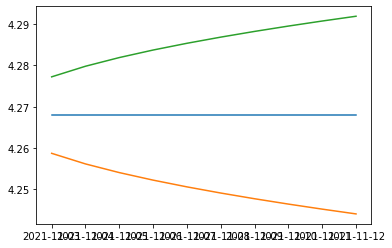

In [27]:
plt.plot(ARIMA(train,order=best_order).fit().get_forecast(10).predicted_mean)
plt.plot(ARIMA(train,order=best_order).fit().get_forecast(10).conf_int())

In [28]:
df = ARIMA(train,order=best_order).fit().get_forecast(10).conf_int()
df['pred'] = ARIMA(train,order=best_order).fit().get_forecast(10).predicted_mean
df

,lower Close,upper Close,pred
2021-11-03,4.258734,4.277250,4.267992
2021-11-04,4.256168,4.279816,4.267992
2021-11-05,4.254068,4.281916,4.267992
2021-11-06,4.252245,4.283739,4.267992
2021-11-07,4.250613,4.285371,4.267992
2021-11-08,4.249121,4.286863,4.267992
2021-11-09,4.247738,4.288246,4.267992
2021-11-10,4.246445,4.289539,4.267992
2021-11-11,4.245224,4.290760,4.267992
2021-11-12,4.244066,4.291918,4.267992


<AxesSubplot:>

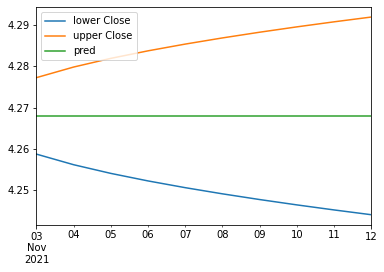

In [29]:
df.plot()

In [30]:
def walk_forward_validation(n_train, test):
    # create dataframe to store the outcome
    result = pd.DataFrame(columns=['forecast', 'lower_interval', 'upper_interval'])
    # predict one point at a time
    for i in range(len(test)):
        # define train set
        train_ = linearized.iloc[:n_train+i, :].copy()
        # train the model
        arima = ARIMA(endog = train_, order=best_order).fit(method_kwargs={"warn_convergence": False})
        # get the forecast
        results = arima.get_forecast(1, alpha=0.05)
        # central
        result.loc[i, 'forecast'] = results.predicted_mean[0]
        # lower interval
        result.loc[i, 'lower_interval'] = results.conf_int().iloc[0, 0]
        # upper interval
        result.loc[i, 'upper_interval'] = results.conf_int().iloc[0, 1]
    # join with test dataframe
    result.index=test.index
    result = result.apply(pd.to_numeric)
    return test.join(result)

result = walk_forward_validation(n_train, test)

In [31]:
result

,Close,forecast,lower_interval,upper_interval
Date,,,,
2021-11-03,4.272957,4.267992,4.258734,4.277250
2021-11-04,4.285037,4.271986,4.262725,4.281247
2021-11-05,4.285175,4.282732,4.273259,4.292205
2021-11-06,4.285175,4.284782,4.275336,4.294229
2021-11-07,4.285175,4.285109,4.275695,4.294522
2021-11-08,4.286278,4.285163,4.275783,4.294544
2021-11-09,4.283103,4.286090,4.276740,4.295439
2021-11-10,4.277973,4.283610,4.274280,4.292940
2021-11-11,4.286829,4.278902,4.269560,4.288244


### we also need a quick baseline model...

**... best prediction for the price tomorrow is the price today**. 🙈

In [32]:
# baseline = tomorrows prediction is todays price
result['base'] = result['Close'].shift()
result['base'].iloc[0] = train.Close[-1]
result.apply(lambda x: np.exp(x).astype('float16')).tail(5) #exp for visualization only

,Close,forecast,lower_interval,upper_interval,base
Date,,,,,
2021-12-27,74.6875,74.6875,73.9375,75.4375,74.6875
2021-12-28,74.6875,74.6875,73.9375,75.4375,74.6875
2021-12-29,75.4375,74.6875,73.9375,75.4375,74.6875
2021-12-30,74.1875,75.3125,74.5625,76.0625,75.4375
2021-12-31,73.5000,74.4375,73.6875,75.1875,74.1875


### Let's evaluate our model visually...

In [33]:
# We define here a "Plot forecast vs. real", which also shows historical train set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

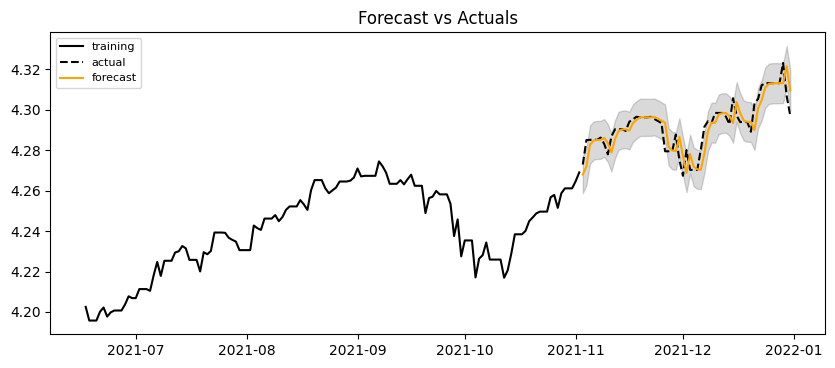

In [34]:
plot_forecast(result.forecast, train, test, np.array(result.upper_interval), np.array(result.lower_interval))

In [35]:
# # plot the forecast
# plt.figure(figsize=(14,8))
# plt.plot(train.Close,
#             label='training', color='black')
# plt.plot(result.Close,
#             label='actual', color='black', ls='--')
# plt.plot(result.forecast,
#             label='forecast', color='orange')
# #plt.plot(result.base, label='dummy prediction', color='green')
# plt.fill_between(result.index,
#                  result.lower_interval,
#                  result.upper_interval,
#                  label='confidence interval', color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.ylabel('stock price')
# plt.legend(loc='upper left', fontsize=12)
# plt.show()

#### compare to our baseline model

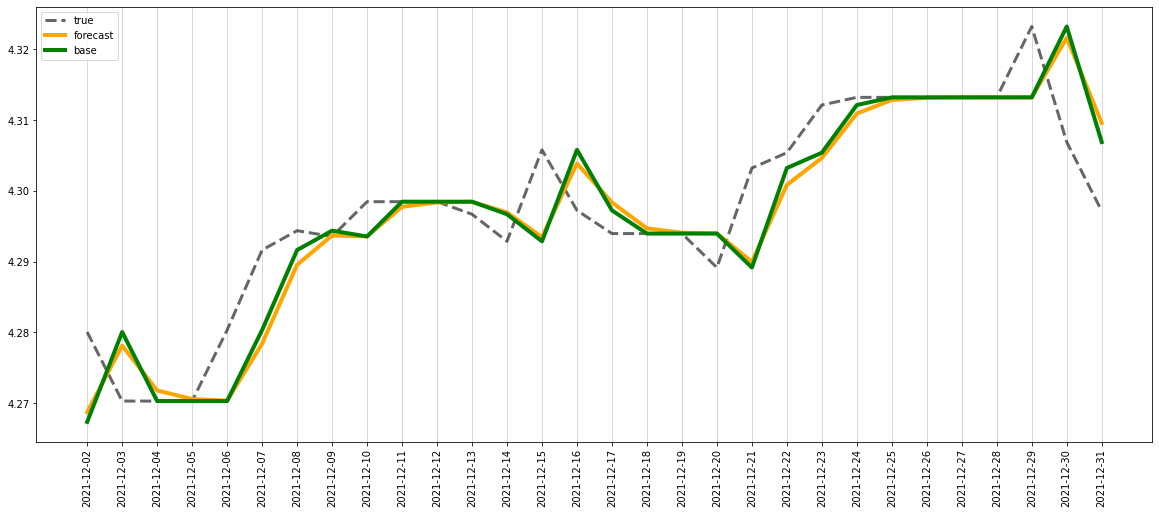

In [36]:
s=-30
plt.figure(figsize=(20,8))
plt.plot(result.Close[s:],lw=3, c='black', ls = "--", alpha=0.6)
plt.plot(result.forecast[s:],color = 'orange', lw=4)
plt.plot(result.base[s:], color='green', lw=4)
plt.xticks(result.index[s::1], rotation=90)
plt.legend(labels=["true", "forecast", "base"])
plt.grid(alpha=0.6, axis="x")

In [37]:
# s=-20
# plt.figure(figsize=(14,8))
# plt.plot(result.Close[s:])
# plt.plot(result.forecast[s:],lw=3)
# plt.plot(result.base[s:],alpha=0.6)
# plt.xticks(result.index[s::1], rotation=45)
# plt.legend(labels=["true", "forecast", "base"])
# plt.grid(axis="x")
# plt.show()

### Let's evaluate using performace metrics...

In [38]:
#https://en.wikipedia.org/wiki/Mean_absolute_scaled_error

In [39]:
# define a function to get MAPE using y_pred, y_true
def get_mape(y_true, y_pred):
    '''takes y_true, y_pred (pandas series)
    returns mean absolute percentage error'''
    mape = 100*((y_true - y_pred)/y_true).abs().mean()
    return round(mape, 2)

# define a function to get MASE using y_pred, y_true
def get_mase(y_true, y_pred, y_train):
    '''takes y_true, y_pred (pandas series)
    returns mean absolute scaled error'''
    mae_test = (y_true - y_pred).abs().mean()
    y_t = y_train
    y_t_1 = y_train.shift(-1)
    mae_train = (y_t - y_t_1).abs().mean()
    return round(mae_test/mae_train, 2)

In [40]:
# MAPE and MASE 
print('mape model:', get_mape(result.Close, result.forecast))
print('mape baseline:', get_mape(result.Close, result.base))
print('')
print('mase model:', get_mase(result.Close, result.forecast, train.Close))
print('mase baseline', get_mase(result.Close, result.base, train.Close))

mape model: 0.1
mape baseline: 0.09

mase model: 1.43
mase baseline 1.33


# Re-compose back to initial time series

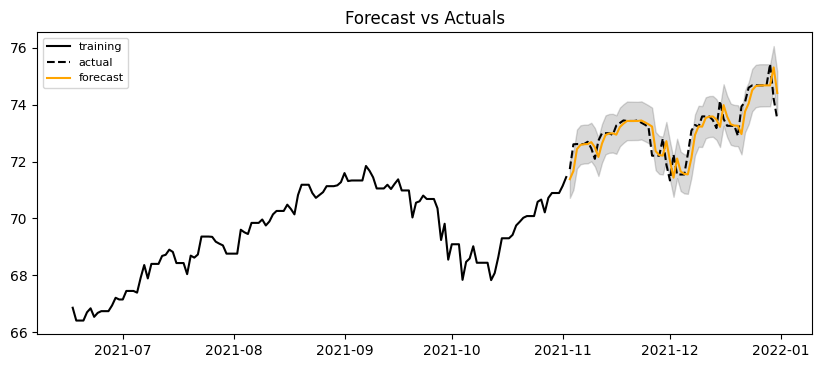

In [41]:
forecast_recons = np.exp(result.forecast)
train_recons = np.exp(train)
test_recons = np.exp(test)
lower_recons = np.array(np.exp(result.lower_interval))
upper_recons = np.array(np.exp(result.upper_interval))

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, upper_recons, lower_recons)

**Another reminder:** ARIMA is short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values. Maybe this assumption is not good enough for precise stock price predictions 😅

**Last words**: This 'investigation' found that the stockprice follows a random walk approach ➡ past price action can not be used to determine future price action.

[More information can be found here.](https://www.investopedia.com/terms/r/randomwalktheory.asp)

In [42]:
print(np.exp(ARIMA(linearized,order=best_order).fit().get_forecast(1).predicted_mean))

2022-01-01    73.624426
Freq: D, dtype: float64
